## Imports

### Libraries

In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchsummary import summary

### Custom

In [2]:
from cv_geoguessr.data.StreetViewImagesDataset import StreetViewImagesDataset

from cv_geoguessr.grid.grid_partitioning import Partitioning

from cv_geoguessr.utils.plot_images import plot_images

## Colab specific

Run only when using Colab.

In [3]:
COLAB = False

if COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

## Model constants

In [4]:
TRAIN_BATCH_SIZE = 32
TEST_BATCH_SIZE = 100
CELL_WIDTH = 0.04

SAMPLES_TO_SHOW = 5

IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406])
IMAGENET_STD = torch.tensor([0.229, 0.224, 0.225])

CITY_BOUNDS_FILE = '../data/metadata/citybounds/london.csv'

COLAB_LONDON_PHOTO_DIR = lambda train: f'/content/drive/MyDrive/Documents/University/2021-2022/CS4245 Computer Vision/data/images/{"train" if train else "test"}/london'
LOCAL_LONDON_PHOTO_DIR = lambda train: f'../data/images/london/{"train" if train else "test"}'
SJOERD_LONDON_PHOTO_DIR = lambda train: f'../data/images/{"train_img" if train else "test_img"}/london/'


LONDON_PHOTO_DIR = SJOERD_LONDON_PHOTO_DIR

SESSION = "second_test"
CHECKPOINT_FOLDER = f'./checkpoints/{SESSION}/'


### ImageNet setup

In [5]:
# !wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt -O imagenet_classes.txt

In [6]:
# with open("imagenet_classes.txt", "r") as f:
#     categories = [s.strip() for s in f.readlines()]

## Download ResNet50

In [7]:
resnet50 = models.resnet50(pretrained=True, progress=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet50.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [8]:
summary(resnet50, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

## Load the data

### Create the data loaders

In [9]:
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(256),
    transforms.CenterCrop((224, 224)),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

grid_partitioning = Partitioning(CITY_BOUNDS_FILE, CELL_WIDTH)

train_data_set = StreetViewImagesDataset(LONDON_PHOTO_DIR(True), grid_partitioning, data_transforms)
train_loader = DataLoader(train_data_set, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
test_data_set = StreetViewImagesDataset(LONDON_PHOTO_DIR(False), grid_partitioning, data_transforms)
test_loader = DataLoader(test_data_set, batch_size=TEST_BATCH_SIZE, shuffle=True)


### Preview some training images

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


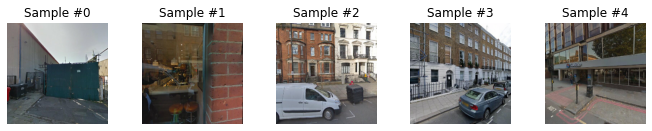

In [10]:
examples = enumerate(test_loader)
batch_idx, (eval_images, eval_coordinates) = next(examples)

plot_images(eval_images[:SAMPLES_TO_SHOW], IMAGENET_MEAN, IMAGENET_STD)

In [11]:
eval_coordinates[0, :]

tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

## Evaluate the model

In [11]:
resnet50.eval()

check_images = eval_images[:SAMPLES_TO_SHOW]

with torch.no_grad():
    output = torch.nn.functional.softmax(resnet50(check_images), dim=1)

In [13]:
for i in output:
    top5_prob, top5_catid = torch.topk(i, 5)

    for i in range(top5_prob.size(0)):
        print(categories[top5_catid[i]], top5_prob[i].item())

    print()

limousine 0.494861900806427
convertible 0.15715351700782776
cab 0.10455919802188873
sports car 0.046823348850011826
beach wagon 0.023714642971754074

dam 0.5563629269599915
prison 0.140448197722435
patio 0.043819084763526917
bannister 0.042140405625104904
castle 0.03014199063181877

planetarium 0.11371709406375885
water tower 0.09709981828927994
prison 0.08581230044364929
dome 0.078342504799366
traffic light 0.07234091311693192

limousine 0.9999208450317383
minivan 5.1376220653764904e-05
police van 5.890528882446233e-06
beach wagon 2.9792192890454317e-06
cab 2.792907707771519e-06

streetcar 0.6648581027984619
trolleybus 0.07793936878442764
passenger car 0.07603776454925537
police van 0.021916277706623077
traffic light 0.0189041867852211



torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


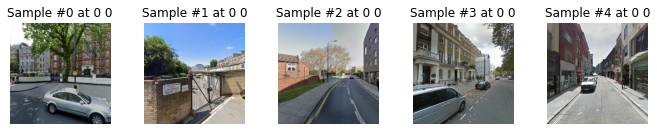

In [14]:
plot_images(check_images, IMAGENET_MEAN, IMAGENET_STD)

## Train on the grid output


In [15]:
from torch.optim import lr_scheduler
from torch import optim

NUMBER_OF_GRID_ELEMENTS = len(grid_partitioning.cells)
resnet50.fc = nn.Linear(resnet50.fc.in_features, NUMBER_OF_GRID_ELEMENTS)
resnet50.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
# We might not want this for the initial few epochs I (sjoerd) think but lets just roll with it
optimizer_ft = optim.SGD(resnet50.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [16]:
summary(resnet50, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [17]:

import copy
from datetime import time

dataloaders = {
    "train": train_loader,
    "val": test_loader
}


dataset_sizes = {
    'train':len(train_data_set),
    'val':len(test_data_set),
}

print(dataset_sizes)

{'train': 10038, 'val': 2000}


In [18]:
import os

if not os.path.isdir(CHECKPOINT_FOLDER):
    os.makedirs(CHECKPOINT_FOLDER)

torch.save(resnet50.state_dict(), CHECKPOINT_FOLDER + "0.ckpt")

In [34]:
import copy
import time

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    """
    Trains a model, based on https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

    :param model: the model to train
    :param criterion: the criterion to use
    :param optimizer: the optimizer to use
    :param scheduler: torch.optim.lr_scheduler
    :param num_epochs:
    :return: a trained model
    """

    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)

                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()



                # statistics
                _, actual_label_index = torch.max(labels, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == actual_label_index)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

        torch.save(resnet50.state_dict(), CHECKPOINT_FOLDER + f"epoch_{epoch}.ckpt")

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [35]:
# Lets train the model
resnet50 = train_model(resnet50, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)


Epoch 0/24
----------
train Loss: 2.1990 Acc: 0.2483
val Loss: 1.9613 Acc: 0.3300

Epoch 1/24
----------
train Loss: 1.7815 Acc: 0.4066
val Loss: 1.8449 Acc: 0.3705

Epoch 2/24
----------
train Loss: 1.3065 Acc: 0.5786
val Loss: 1.9274 Acc: 0.3775

Epoch 3/24
----------
train Loss: 0.7119 Acc: 0.7964
val Loss: 2.1704 Acc: 0.3770

Epoch 4/24
----------
train Loss: 0.2982 Acc: 0.9365
val Loss: 2.3770 Acc: 0.3610

Epoch 5/24
----------
train Loss: 0.1245 Acc: 0.9759
val Loss: 2.5373 Acc: 0.3745

Epoch 6/24
----------
train Loss: 0.0666 Acc: 0.9888
val Loss: 2.6183 Acc: 0.3775

Epoch 7/24
----------
train Loss: 0.0417 Acc: 0.9944
val Loss: 2.6118 Acc: 0.3750

Epoch 8/24
----------
train Loss: 0.0381 Acc: 0.9957
val Loss: 2.6160 Acc: 0.3810

Epoch 9/24
----------
train Loss: 0.0366 Acc: 0.9958
val Loss: 2.6268 Acc: 0.3820

Epoch 10/24
----------
train Loss: 0.0338 Acc: 0.9971
val Loss: 2.6485 Acc: 0.3805

Epoch 11/24
----------
train Loss: 0.0319 Acc: 0.9968
val Loss: 2.6319 Acc: 0.3790

Ep